In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
from dataset import prepare, assemble, transform
import regressor
import utils
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Conv2D, Flatten
from keras.utils import multi_gpu_model
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from plot_utils import show_some

In [3]:
def build_model2():
    nb_filters = 8
    model = Sequential()
    model.add(Conv2D(filters=nb_filters, kernel_size=5, activation='relu', input_shape=(128,128,1)))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, 5))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2))
    model.add(Activation('softmax'))
    model = multi_gpu_model(model, gpus=4)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
df = assemble.get_dataset_df('/data/staff/common/ML-crystals/fakeset2/fake.csv', has_meta=False)

In [5]:
count_0 = len(df[df['y'] == 0])
count_1 = len(df[df['y'] == 1])
count_0, count_1

(16726, 3274)

In [6]:
excess = df[(df['y'] == 0)].sample(n=count_0-count_1)
df = df.drop(excess.index)

In [7]:
def load_images(df):
    df = transform.row_map(df, 'img', transform.raw_img, args=(False,))
    df = transform.row_map(df, 'img', transform.normed_img)
    df = transform.aug_hflip(df)
    return df


def onehot(y):
    return np.array(list(map(lambda a: [a==0, a==1], y)))

def xygen(dfgen):
    for df in dfgen:
        df = load_images(df)
        x, y = assemble.df_to_xy(df, dict(input_shape=(128,128,1)))
        y = onehot(y)
        yield (x, y)

def train(model, df, val_df):
    bs = 64
    gen = xygen(assemble.dataset_batch_generator(df, batch_size=bs))
    val_gen = xygen(assemble.dataset_batch_generator(df, batch_size=bs))
    model.fit_generator(gen, validation_data=val_gen, epochs=4, steps_per_epoch=len(df)//bs, validation_steps=len(val_df)//bs)

In [8]:
md = build_model2()

In [9]:
val = df.sample(frac=0.2)
trn = df.drop(val.index)

In [10]:
train(md, trn, val)

100%|██████████| 64/64 [00:00<00:00, 761.48it/s]

100%|██████████| 64/64 [00:00<00:00, 775.16it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/4
row mapping raw_img
row mapping raw_img
row mapping normed_img
row mapping normed_img
flip augmentation
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 518.10it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping raw_img
row mapping normed_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 371.12it/s]

100%|██████████| 64/64 [00:00<00:00, 379.13it/s]

100%|██████████| 64/64 [00:00<00:00, 3588.37it/s]

100%|██████████| 64/64 [00:00<00:00, 2397.69it/s]

100%|██████████| 64/64 [00:00<00:00, 800.75it/s]

100%|██████████| 64/64 [00:00<00:00, 793.93it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
flip augmentation
row mapping raw_img
row mapping raw_img
row mapping normed_img
row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 782.36it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img
row mapping raw_img
row mapping normed_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 695.26it/s]

100%|██████████| 64/64 [00:00<00:00, 693.68it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
flip augmentation
row mapping raw_img
row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 347.53it/s]

100%|██████████| 64/64 [00:00<00:00, 352.77it/s]

100%|██████████| 64/64 [00:00<00:00, 629.96it/s]

100%|██████████| 64/64 [00:00<00:00, 669.93it/s]

  0%|          | 0/64 [00:00<?, ?it/s]


row mapping normed_img
row mapping normed_img
flip augmentation
flip augmentation
row mapping raw_imgrow mapping raw_img

row mapping normed_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 847.52it/s]

100%|██████████| 64/64 [00:00<00:00, 2353.99it/s]

100%|██████████| 64/64 [00:00<00:00, 879.12it/s]

100%|██████████| 64/64 [00:00<00:00, 1195.42it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
flip augmentation
row mapping raw_img
row mapping raw_img
row mapping normed_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 790.08it/s]

100%|██████████| 64/64 [00:00<00:00, 885.32it/s]

100%|██████████| 64/64 [00:00<00:00, 1007.44it/s]

100%|██████████| 64/64 [00:00<00:00, 986.28it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
flip augmentation
row mapping raw_img
row mapping raw_img
row mapping normed_img
row mapping normed_img
flip augmentation
flip augmentation
row mapping raw_img
row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 1001.44it/s]

100%|██████████| 64/64 [00:00<00:00, 985.08it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
row mapping normed_img
flip augmentation
flip augmentation
row mapping raw_img
row mapping raw_img
row mapping normed_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 974.81it/s]

100%|██████████| 64/64 [00:00<00:00, 956.76it/s]

100%|██████████| 64/64 [00:00<00:00, 1051.76it/s]

100%|██████████| 64/64 [00:00<00:00, 1034.93it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
flip augmentation
row mapping raw_img
row mapping raw_img
row mapping normed_img
row mapping normed_img
flip augmentation
flip augmentation
row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 6622.97it/s]


row mapping normed_img
flip augmentation
 1/81 [..............................] - ETA: 9:23 - loss: 0.7154 - acc: 0.4531

100%|██████████| 64/64 [00:00<00:00, 2945.54it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 2/81 [..............................] - ETA: 4:46 - loss: 0.8920 - acc: 0.5000

100%|██████████| 64/64 [00:00<00:00, 5193.48it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
 3/81 [>.............................] - ETA: 3:14 - loss: 0.8560 - acc: 0.5208

100%|██████████| 64/64 [00:00<00:00, 5240.94it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 4/81 [>.............................] - ETA: 2:27 - loss: 0.7922 - acc: 0.5586

100%|██████████| 64/64 [00:00<00:00, 4705.43it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 5/81 [>.............................] - ETA: 2:00 - loss: 0.7656 - acc: 0.5828

100%|██████████| 64/64 [00:00<00:00, 4645.74it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
 6/81 [=>............................] - ETA: 1:41 - loss: 0.7446 - acc: 0.6159

100%|██████████| 64/64 [00:00<00:00, 5003.92it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 7/81 [=>............................] - ETA: 1:28 - loss: 0.7266 - acc: 0.6395

100%|██████████| 64/64 [00:00<00:00, 4708.49it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 8/81 [=>............................] - ETA: 1:18 - loss: 0.7035 - acc: 0.6631

100%|██████████| 64/64 [00:00<00:00, 5098.20it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 9/81 [==>...........................] - ETA: 1:10 - loss: 0.6637 - acc: 0.6892

100%|██████████| 64/64 [00:00<00:00, 4938.38it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


10/81 [==>...........................] - ETA: 1:04 - loss: 0.6230 - acc: 0.7078

100%|██████████| 64/64 [00:00<00:00, 4137.61it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


11/81 [===>..........................] - ETA: 59s - loss: 0.5858 - acc: 0.7266 

100%|██████████| 64/64 [00:00<00:00, 4448.94it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


12/81 [===>..........................] - ETA: 54s - loss: 0.6144 - acc: 0.7311

100%|██████████| 64/64 [00:00<00:00, 5449.36it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


13/81 [===>..........................] - ETA: 50s - loss: 0.6005 - acc: 0.7428

100%|██████████| 64/64 [00:00<00:00, 5361.10it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


14/81 [====>.........................] - ETA: 47s - loss: 0.5907 - acc: 0.7472

100%|██████████| 64/64 [00:00<00:00, 3610.09it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
15/81 [====>.........................] - ETA: 44s - loss: 0.5899 - acc: 0.7510


100%|██████████| 64/64 [00:00<00:00, 4291.05it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
16/81 [====>.........................] - ETA: 42s - loss: 0.5807 - acc: 0.7563

100%|██████████| 64/64 [00:00<00:00, 5195.79it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


17/81 [=====>........................] - ETA: 40s - loss: 0.5742 - acc: 0.7638

100%|██████████| 64/64 [00:00<00:00, 5005.88it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
18/81 [=====>........................] - ETA: 37s - loss: 0.5748 - acc: 0.7635


100%|██████████| 64/64 [00:00<00:00, 4406.00it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


19/81 [======>.......................] - ETA: 36s - loss: 0.5769 - acc: 0.7574

100%|██████████| 64/64 [00:00<00:00, 5811.05it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
20/81 [======>.......................] - ETA: 34s - loss: 0.5750 - acc: 0.7625

100%|██████████| 64/64 [00:00<00:00, 4877.90it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


21/81 [======>.......................] - ETA: 32s - loss: 0.5697 - acc: 0.7679

100%|██████████| 64/64 [00:00<00:00, 4674.54it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


22/81 [=======>......................] - ETA: 31s - loss: 0.5613 - acc: 0.7717

100%|██████████| 64/64 [00:00<00:00, 4964.96it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


23/81 [=======>......................] - ETA: 30s - loss: 0.5509 - acc: 0.7758

100%|██████████| 64/64 [00:00<00:00, 4389.64it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


24/81 [=======>......................] - ETA: 28s - loss: 0.5362 - acc: 0.7826

100%|██████████| 64/64 [00:00<00:00, 4627.48it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


25/81 [========>.....................] - ETA: 27s - loss: 0.5205 - acc: 0.7897

100%|██████████| 64/64 [00:00<00:00, 5290.41it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


26/81 [========>.....................] - ETA: 26s - loss: 0.5153 - acc: 0.7930

100%|██████████| 64/64 [00:00<00:00, 4595.55it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


27/81 [=========>....................] - ETA: 25s - loss: 0.5049 - acc: 0.7972

100%|██████████| 64/64 [00:00<00:00, 4297.31it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


28/81 [=========>....................] - ETA: 24s - loss: 0.4956 - acc: 0.8013

100%|██████████| 64/64 [00:00<00:00, 4709.15it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


29/81 [=========>....................] - ETA: 23s - loss: 0.4876 - acc: 0.8050

100%|██████████| 64/64 [00:00<00:00, 4425.10it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
30/81 [==========>...................] - ETA: 22s - loss: 0.4790 - acc: 0.8089row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5152.21it/s]



row mapping normed_img
flip augmentation
31/81 [==========>...................] - ETA: 22s - loss: 0.4662 - acc: 0.8140

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4291.47it/s]

row mapping normed_img
flip augmentation


32/81 [==========>...................] - ETA: 21s - loss: 0.4609 - acc: 0.8154

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4990.62it/s]

row mapping normed_img
flip augmentation


33/81 [===========>..................] - ETA: 20s - loss: 0.4538 - acc: 0.8182

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4911.90it/s]

row mapping normed_img
flip augmentation


34/81 [===========>..................] - ETA: 19s - loss: 0.4454 - acc: 0.8210

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5758.56it/s]


flip augmentation
35/81 [===========>..................] - ETA: 19s - loss: 0.4404 - acc: 0.8237row mapping raw_img

  0%|          | 0/64 [00:00<?, ?it/s]


row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5380.76it/s]

flip augmentation


36/81 [============>.................] - ETA: 18s - loss: 0.4329 - acc: 0.8266

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 5363.02it/s]


37/81 [============>.................] - ETA: 17s - loss: 0.4253 - acc: 0.8300

100%|██████████| 64/64 [00:00<00:00, 4950.40it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


38/81 [=============>................] - ETA: 17s - loss: 0.4201 - acc: 0.8326

100%|██████████| 64/64 [00:00<00:00, 5402.31it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


39/81 [=============>................] - ETA: 16s - loss: 0.4163 - acc: 0.8335

100%|██████████| 64/64 [00:00<00:00, 5175.46it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


40/81 [=============>................] - ETA: 16s - loss: 0.4102 - acc: 0.8365

100%|██████████| 64/64 [00:00<00:00, 5158.95it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


41/81 [==============>...............] - ETA: 15s - loss: 0.4037 - acc: 0.8384

100%|██████████| 64/64 [00:00<00:00, 5078.43it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


42/81 [==============>...............] - ETA: 15s - loss: 0.4010 - acc: 0.8400

100%|██████████| 64/64 [00:00<00:00, 5192.18it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
43/81 [==============>...............] - ETA: 14s - loss: 0.3942 - acc: 0.8428

100%|██████████| 64/64 [00:00<00:00, 5184.25it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


44/81 [===============>..............] - ETA: 14s - loss: 0.3896 - acc: 0.8445

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5198.71it/s]

row mapping normed_img
flip augmentation
45/81 [===============>..............] - ETA: 13s - loss: 0.3842 - acc: 0.8465


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5175.16it/s]


flip augmentation
46/81 [================>.............] - ETA: 13s - loss: 0.3802 - acc: 0.8485

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5283.95it/s]

flip augmentation


47/81 [================>.............] - ETA: 12s - loss: 0.3777 - acc: 0.8497

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5159.44it/s]

flip augmentation


48/81 [================>.............] - ETA: 12s - loss: 0.3735 - acc: 0.8516

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 5516.55it/s]


49/81 [=================>............] - ETA: 11s - loss: 0.3709 - acc: 0.8533

100%|██████████| 64/64 [00:00<00:00, 5133.39it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


50/81 [=================>............] - ETA: 11s - loss: 0.3677 - acc: 0.8548

100%|██████████| 64/64 [00:00<00:00, 5454.67it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
51/81 [=================>............] - ETA: 10s - loss: 0.3636 - acc: 0.8562

100%|██████████| 64/64 [00:00<00:00, 5858.86it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
52/81 [==================>...........] - ETA: 10s - loss: 0.3589 - acc: 0.8582


100%|██████████| 64/64 [00:00<00:00, 5770.08it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


53/81 [==================>...........] - ETA: 9s - loss: 0.3560 - acc: 0.8588 

100%|██████████| 64/64 [00:00<00:00, 4716.51it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


54/81 [===================>..........] - ETA: 9s - loss: 0.3536 - acc: 0.8595

100%|██████████| 64/64 [00:00<00:00, 4731.89it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
55/81 [===================>..........] - ETA: 9s - loss: 0.3508 - acc: 0.8609


100%|██████████| 64/64 [00:00<00:00, 5120.47it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
56/81 [===================>..........] - ETA: 8s - loss: 0.3482 - acc: 0.8617

100%|██████████| 64/64 [00:00<00:00, 4838.68it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


57/81 [====================>.........] - ETA: 8s - loss: 0.3439 - acc: 0.8633

100%|██████████| 64/64 [00:00<00:00, 5116.47it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


58/81 [====================>.........] - ETA: 7s - loss: 0.3430 - acc: 0.8636

100%|██████████| 64/64 [00:00<00:00, 4418.25it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


59/81 [====================>.........] - ETA: 7s - loss: 0.3413 - acc: 0.8647

100%|██████████| 64/64 [00:00<00:00, 3486.90it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


60/81 [=====================>........] - ETA: 7s - loss: 0.3378 - acc: 0.8655

100%|██████████| 64/64 [00:00<00:00, 5150.43it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


61/81 [=====================>........] - ETA: 6s - loss: 0.3357 - acc: 0.8662

100%|██████████| 64/64 [00:00<00:00, 4409.98it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


62/81 [=====================>........] - ETA: 6s - loss: 0.3339 - acc: 0.8666

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
63/81 [======================>.......] - ETA: 5s - loss: 0.3323 - acc: 0.8671

100%|██████████| 64/64 [00:00<00:00, 5554.79it/s]


flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation
64/81 [======================>.......] - ETA: 5s - loss: 0.3307 - acc: 0.8677

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5794.86it/s]


row mapping normed_img
flip augmentation
65/81 [=======================>......] - ETA: 5s - loss: 0.3293 - acc: 0.8681

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5454.67it/s]

row mapping normed_img
flip augmentation


66/81 [=======================>......] - ETA: 4s - loss: 0.3271 - acc: 0.8688

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4606.59it/s]

row mapping normed_img
flip augmentation


67/81 [=======================>......] - ETA: 4s - loss: 0.3252 - acc: 0.8699

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4364.31it/s]

row mapping normed_img
flip augmentation


68/81 [========================>.....] - ETA: 4s - loss: 0.3224 - acc: 0.8711

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4105.65it/s]

row mapping normed_img
flip augmentation


69/81 [========================>.....] - ETA: 3s - loss: 0.3217 - acc: 0.8721

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5095.39it/s]


row mapping normed_img
flip augmentation
70/81 [========================>.....] - ETA: 3s - loss: 0.3187 - acc: 0.8733

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5322.51it/s]

row mapping normed_img
flip augmentation


71/81 [=========================>....] - ETA: 3s - loss: 0.3169 - acc: 0.8738

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5158.45it/s]

row mapping normed_img
flip augmentation


72/81 [=========================>....] - ETA: 2s - loss: 0.3141 - acc: 0.8748

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5223.50it/s]

row mapping normed_img
flip augmentation
73/81 [==========================>...] - ETA: 2s - loss: 0.3123 - acc: 0.8754


100%|██████████| 64/64 [00:00<00:00, 1230.10it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4558.95it/s]


flip augmentation


74/81 [==========================>...] - ETA: 2s - loss: 0.3105 - acc: 0.8761row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4620.15it/s]

row mapping normed_img
flip augmentation
75/81 [==========================>...] - ETA: 1s - loss: 0.3083 - acc: 0.8769


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5204.46it/s]


flip augmentation
76/81 [===========================>..] - ETA: 1s - loss: 0.3069 - acc: 0.8774

100%|██████████| 64/64 [00:00<00:00, 1235.87it/s]

row mapping raw_img



100%|██████████| 64/64 [00:00<00:00, 4553.46it/s]

row mapping normed_img
flip augmentation
77/81 [===========================>..] - ETA: 1s - loss: 0.3057 - acc: 0.8780


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 1217.17it/s]


row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5598.24it/s]


flip augmentation
78/81 [===========================>..] - ETA: 0s - loss: 0.3035 - acc: 0.8791

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5628.99it/s]


flip augmentation
79/81 [============================>.] - ETA: 0s - loss: 0.3008 - acc: 0.8803

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5574.06it/s]

flip augmentation
80/81 [============================>.] - ETA: 0s - loss: 0.2981 - acc: 0.8814


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 5830.61it/s]


row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4458.54it/s]

row mapping normed_img
flip augmentation



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 1427.78it/s]


flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
81/81 [==============================] - 27s 333ms/step - loss: 0.2954 - acc: 0.8827 - val_loss: 0.1577 - val_acc: 0.9348



100%|██████████| 64/64 [00:00<00:00, 1419.65it/s]

100%|██████████| 64/64 [00:00<00:00, 1052.86it/s]

100%|██████████| 64/64 [00:00<00:00, 997.71it/s]

100%|██████████| 64/64 [00:00<00:00, 3126.65it/s]


Epoch 2/4
row mapping raw_img
row mapping normed_img
row mapping normed_img
flip augmentation
flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
 1/81 [..............................] - ETA: 17s - loss: 0.1279 - acc: 0.9688


100%|██████████| 64/64 [00:00<00:00, 977.31it/s]

100%|██████████| 64/64 [00:00<00:00, 967.73it/s]

100%|██████████| 64/64 [00:00<00:00, 3424.05it/s]

row mapping raw_img
flip augmentation
row mapping normed_img
row mapping raw_img
row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation


100%|██████████| 64/64 [00:00<00:00, 5440.41it/s]

 2/81 [..............................] - ETA: 17s - loss: 0.1980 - acc: 0.9492


100%|██████████| 64/64 [00:00<00:00, 1239.65it/s]

100%|██████████| 64/64 [00:00<00:00, 1392.17it/s]

100%|██████████| 64/64 [00:00<00:00, 989.86it/s]

100%|██████████| 64/64 [00:00<00:00, 1044.61it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping raw_img
row mapping normed_img
row mapping normed_img
flip augmentation
flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
 3/81 [>.............................] - ETA: 16s - loss: 0.2119 - acc: 0.9349


100%|██████████| 64/64 [00:00<00:00, 1223.04it/s]

100%|██████████| 64/64 [00:00<00:00, 1408.47it/s]

100%|██████████| 64/64 [00:00<00:00, 3148.47it/s]

100%|██████████| 64/64 [00:00<00:00, 1109.71it/s]

100%|██████████| 64/64 [00:00<00:00, 1701.41it/s]

100%|██████████| 64/64 [00:00<00:00, 5685.63it/s]


row mapping raw_img
flip augmentation
row mapping normed_img
row mapping raw_img
flip augmentation
row mapping normed_img
flip augmentation
 4/81 [>.............................] - ETA: 16s - loss: 0.1983 - acc: 0.9355

100%|██████████| 64/64 [00:00<00:00, 4975.17it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
 5/81 [>.............................] - ETA: 16s - loss: 0.1962 - acc: 0.9375

100%|██████████| 64/64 [00:00<00:00, 4529.18it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 6/81 [=>............................] - ETA: 16s - loss: 0.1805 - acc: 0.9427

100%|██████████| 64/64 [00:00<00:00, 5352.65it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
 7/81 [=>............................] - ETA: 16s - loss: 0.1852 - acc: 0.9364


100%|██████████| 64/64 [00:00<00:00, 5568.39it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
 8/81 [=>............................] - ETA: 15s - loss: 0.1817 - acc: 0.9365

100%|██████████| 64/64 [00:00<00:00, 5116.47it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
 9/81 [==>...........................] - ETA: 15s - loss: 0.1853 - acc: 0.9332


100%|██████████| 64/64 [00:00<00:00, 5176.66it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


10/81 [==>...........................] - ETA: 15s - loss: 0.1739 - acc: 0.9398

100%|██████████| 64/64 [00:00<00:00, 4857.24it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
11/81 [===>..........................] - ETA: 15s - loss: 0.1633 - acc: 0.9439


100%|██████████| 64/64 [00:00<00:00, 5077.18it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
12/81 [===>..........................] - ETA: 14s - loss: 0.1641 - acc: 0.9440

100%|██████████| 64/64 [00:00<00:00, 5305.05it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
13/81 [===>..........................] - ETA: 14s - loss: 0.1678 - acc: 0.9423

100%|██████████| 64/64 [00:00<00:00, 5340.19it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
14/81 [====>.........................] - ETA: 14s - loss: 0.1602 - acc: 0.9448row mapping raw_img



100%|██████████| 64/64 [00:00<00:00, 4996.56it/s]


row mapping normed_img
flip augmentation
15/81 [====>.........................] - ETA: 14s - loss: 0.1627 - acc: 0.9417

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4316.52it/s]

row mapping normed_img
flip augmentation


16/81 [====>.........................] - ETA: 14s - loss: 0.1664 - acc: 0.9409

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4775.58it/s]


row mapping normed_img
flip augmentation
17/81 [=====>........................] - ETA: 13s - loss: 0.1685 - acc: 0.9389

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4355.88it/s]

row mapping normed_img
flip augmentation
18/81 [=====>........................] - ETA: 13s - loss: 0.1702 - acc: 0.9384row mapping raw_img



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4523.46it/s]


flip augmentation
19/81 [======>.......................] - ETA: 13s - loss: 0.1723 - acc: 0.9359

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4971.67it/s]

flip augmentation


20/81 [======>.......................] - ETA: 13s - loss: 0.1727 - acc: 0.9359

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5192.68it/s]

row mapping normed_img
flip augmentation


21/81 [======>.......................] - ETA: 13s - loss: 0.1738 - acc: 0.9349

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4689.98it/s]

row mapping normed_img
flip augmentation


22/81 [=======>......................] - ETA: 13s - loss: 0.1738 - acc: 0.9347

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4223.14it/s]

row mapping normed_img
flip augmentation


23/81 [=======>......................] - ETA: 12s - loss: 0.1704 - acc: 0.9372

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4437.90it/s]

row mapping normed_img
flip augmentation


24/81 [=======>......................] - ETA: 12s - loss: 0.1677 - acc: 0.9385

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4156.51it/s]

row mapping normed_img
flip augmentation


25/81 [========>.....................] - ETA: 12s - loss: 0.1635 - acc: 0.9406

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3729.00it/s]

row mapping normed_img
flip augmentation


26/81 [========>.....................] - ETA: 12s - loss: 0.1621 - acc: 0.9414

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4467.45it/s]

row mapping normed_img
flip augmentation


27/81 [=========>....................] - ETA: 11s - loss: 0.1633 - acc: 0.9404

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3432.28it/s]

row mapping normed_img
flip augmentation


28/81 [=========>....................] - ETA: 11s - loss: 0.1608 - acc: 0.9414

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4618.16it/s]

row mapping normed_img
flip augmentation
29/81 [=========>....................] - ETA: 11s - loss: 0.1610 - acc: 0.9410


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4347.06it/s]

row mapping normed_img
flip augmentation


30/81 [==========>...................] - ETA: 11s - loss: 0.1610 - acc: 0.9411

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3623.20it/s]

row mapping normed_img
flip augmentation


31/81 [==========>...................] - ETA: 11s - loss: 0.1577 - acc: 0.9423

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4463.06it/s]

row mapping normed_img
flip augmentation


32/81 [==========>...................] - ETA: 10s - loss: 0.1549 - acc: 0.9431

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5142.54it/s]

row mapping normed_img
flip augmentation


33/81 [===========>..................] - ETA: 10s - loss: 0.1595 - acc: 0.9429

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4120.71it/s]

row mapping normed_img
flip augmentation


34/81 [===========>..................] - ETA: 10s - loss: 0.1566 - acc: 0.9437

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4241.02it/s]

row mapping normed_img
flip augmentation


35/81 [===========>..................] - ETA: 10s - loss: 0.1560 - acc: 0.9437

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5244.21it/s]


flip augmentation
36/81 [============>.................] - ETA: 9s - loss: 0.1554 - acc: 0.9434 

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4684.66it/s]

flip augmentation


37/81 [============>.................] - ETA: 9s - loss: 0.1538 - acc: 0.9443

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4455.58it/s]

flip augmentation
38/81 [=============>................] - ETA: 9s - loss: 0.1531 - acc: 0.9439row mapping raw_img



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 5005.88it/s]


39/81 [=============>................] - ETA: 9s - loss: 0.1530 - acc: 0.9435

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4508.87it/s]

row mapping normed_img
flip augmentation


40/81 [=============>................] - ETA: 9s - loss: 0.1543 - acc: 0.9424

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4490.99it/s]

row mapping normed_img
flip augmentation


41/81 [==============>...............] - ETA: 8s - loss: 0.1533 - acc: 0.9426

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5089.69it/s]

row mapping normed_img
flip augmentation
42/81 [==============>...............] - ETA: 8s - loss: 0.1517 - acc: 0.9433


100%|██████████| 64/64 [00:00<00:00, 1221.08it/s]


row mapping raw_img
row mapping normed_img

100%|██████████| 64/64 [00:00<00:00, 5234.19it/s]



flip augmentation
43/81 [==============>...............] - ETA: 8s - loss: 0.1521 - acc: 0.9433

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4524.83it/s]

flip augmentation


44/81 [===============>..............] - ETA: 8s - loss: 0.1524 - acc: 0.9435

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4851.54it/s]

flip augmentation


45/81 [===============>..............] - ETA: 7s - loss: 0.1524 - acc: 0.9432

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 3722.94it/s]

flip augmentation


46/81 [================>.............] - ETA: 7s - loss: 0.1509 - acc: 0.9436

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4415.06it/s]


flip augmentation
47/81 [================>.............] - ETA: 7s - loss: 0.1510 - acc: 0.9437

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 3803.76it/s]

flip augmentation


48/81 [================>.............] - ETA: 7s - loss: 0.1519 - acc: 0.9435

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4314.92it/s]

flip augmentation


49/81 [=================>............] - ETA: 7s - loss: 0.1499 - acc: 0.9440

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4518.20it/s]

flip augmentation


50/81 [=================>............] - ETA: 6s - loss: 0.1511 - acc: 0.9433

100%|██████████| 64/64 [00:00<00:00, 1253.42it/s]

row mapping raw_img



100%|██████████| 64/64 [00:00<00:00, 4553.30it/s]

row mapping normed_img
flip augmentation
51/81 [=================>............] - ETA: 6s - loss: 0.1507 - acc: 0.9432row mapping raw_img



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4202.91it/s]


flip augmentation
52/81 [==================>...........] - ETA: 6s - loss: 0.1505 - acc: 0.9431

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4430.72it/s]

flip augmentation


53/81 [==================>...........] - ETA: 6s - loss: 0.1496 - acc: 0.9432

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4775.50it/s]

flip augmentation


54/81 [===================>..........] - ETA: 5s - loss: 0.1493 - acc: 0.9430

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4562.98it/s]

flip augmentation


55/81 [===================>..........] - ETA: 5s - loss: 0.1500 - acc: 0.9428

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 4340.67it/s]


56/81 [===================>..........] - ETA: 5s - loss: 0.1500 - acc: 0.9429

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3676.39it/s]


row mapping normed_img
flip augmentation
57/81 [====================>.........] - ETA: 5s - loss: 0.1509 - acc: 0.9428

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4781.54it/s]

row mapping normed_img
flip augmentation


58/81 [====================>.........] - ETA: 5s - loss: 0.1500 - acc: 0.9432

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4882.86it/s]

row mapping normed_img
flip augmentation


59/81 [====================>.........] - ETA: 4s - loss: 0.1499 - acc: 0.9429

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3344.82it/s]

row mapping normed_img
flip augmentation


60/81 [=====================>........] - ETA: 4s - loss: 0.1495 - acc: 0.9432

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5047.39it/s]

row mapping normed_img
flip augmentation


61/81 [=====================>........] - ETA: 4s - loss: 0.1487 - acc: 0.9431

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5092.98it/s]

row mapping normed_img
flip augmentation


62/81 [=====================>........] - ETA: 4s - loss: 0.1489 - acc: 0.9434

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5012.43it/s]

row mapping normed_img
flip augmentation
63/81 [======================>.......] - ETA: 3s - loss: 0.1492 - acc: 0.9435


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4454.10it/s]

row mapping normed_img
flip augmentation


64/81 [======================>.......] - ETA: 3s - loss: 0.1509 - acc: 0.9427

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4419.56it/s]

row mapping normed_img
flip augmentation
65/81 [=======================>......] - ETA: 3s - loss: 0.1505 - acc: 0.9427


100%|██████████| 64/64 [00:00<00:00, 1246.47it/s]

row mapping raw_img



100%|██████████| 64/64 [00:00<00:00, 4426.49it/s]


row mapping normed_img
flip augmentation
66/81 [=======================>......] - ETA: 3s - loss: 0.1515 - acc: 0.9420

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4563.21it/s]

row mapping normed_img
flip augmentation


67/81 [=======================>......] - ETA: 3s - loss: 0.1517 - acc: 0.9417

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4530.40it/s]

row mapping normed_img
flip augmentation


68/81 [========================>.....] - ETA: 2s - loss: 0.1512 - acc: 0.9423

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4651.05it/s]

row mapping normed_img
flip augmentation


69/81 [========================>.....] - ETA: 2s - loss: 0.1512 - acc: 0.9419

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4246.99it/s]

row mapping normed_img
flip augmentation
70/81 [========================>.....] - ETA: 2s - loss: 0.1509 - acc: 0.9417


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5750.05it/s]


flip augmentation
71/81 [=========================>....] - ETA: 2s - loss: 0.1497 - acc: 0.9422

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5041.42it/s]

flip augmentation
72/81 [=========================>....] - ETA: 1s - loss: 0.1499 - acc: 0.9424


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5713.22it/s]


row mapping normed_img
flip augmentation
73/81 [==========================>...] - ETA: 1s - loss: 0.1491 - acc: 0.9429

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5736.29it/s]

row mapping normed_img
flip augmentation


74/81 [==========================>...] - ETA: 1s - loss: 0.1483 - acc: 0.9429

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3444.00it/s]

row mapping normed_img
flip augmentation
75/81 [==========================>...] - ETA: 1s - loss: 0.1488 - acc: 0.9427


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5174.96it/s]

row mapping normed_img
flip augmentation
76/81 [===========================>..] - ETA: 1s - loss: 0.1479 - acc: 0.9429


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4828.32it/s]


flip augmentation
77/81 [===========================>..] - ETA: 0s - loss: 0.1475 - acc: 0.9431

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 3972.88it/s]

flip augmentation


78/81 [===========================>..] - ETA: 0s - loss: 0.1468 - acc: 0.9431

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4499.72it/s]


flip augmentation
79/81 [============================>.] - ETA: 0s - loss: 0.1458 - acc: 0.9434

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4587.54it/s]

flip augmentation
80/81 [============================>.] - ETA: 0s - loss: 0.1445 - acc: 0.9439row mapping raw_img



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 5543.21it/s]


row mapping raw_img
row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation
row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5614.86it/s]


row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5172.47it/s]

row mapping normed_img
flip augmentation



100%|██████████| 64/64 [00:00<00:00, 5770.45it/s]


row mapping raw_img
row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5770.94it/s]


row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
81/81 [==============================] - 19s 237ms/step - loss: 0.1432 - acc: 0.9443 - val_loss: 0.0704 - val_acc: 0.9695



100%|██████████| 64/64 [00:00<00:00, 1522.09it/s]

100%|██████████| 64/64 [00:00<00:00, 1066.70it/s]



Epoch 3/4
row mapping raw_img
row mapping normed_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 972.24it/s]

100%|██████████| 64/64 [00:00<00:00, 3177.65it/s]

flip augmentation


100%|██████████| 64/64 [00:00<00:00, 1779.83it/s]

flip augmentation
row mapping raw_img



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
 1/81 [..............................] - ETA: 17s - loss: 0.0371 - acc: 0.9922


100%|██████████| 64/64 [00:00<00:00, 1428.25it/s]

100%|██████████| 64/64 [00:00<00:00, 1132.29it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
flip augmentation
row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 1508.12it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 888.77it/s]

100%|██████████| 64/64 [00:00<00:00, 1004.90it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
flip augmentation
row mapping raw_img
 2/81 [..............................] - ETA: 17s - loss: 0.1236 - acc: 0.9727


100%|██████████| 64/64 [00:00<00:00, 1721.34it/s]

100%|██████████| 64/64 [00:00<00:00, 1127.19it/s]


row mapping raw_img
row mapping normed_img
row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 5148.85it/s]


flip augmentation
 3/81 [>.............................] - ETA: 17s - loss: 0.1522 - acc: 0.9688

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 4413.68it/s]


 4/81 [>.............................] - ETA: 16s - loss: 0.1508 - acc: 0.9590

100%|██████████| 64/64 [00:00<00:00, 4444.59it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 5/81 [>.............................] - ETA: 16s - loss: 0.1404 - acc: 0.9578

100%|██████████| 64/64 [00:00<00:00, 4846.54it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 6/81 [=>............................] - ETA: 16s - loss: 0.1435 - acc: 0.9557

100%|██████████| 64/64 [00:00<00:00, 4828.15it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 7/81 [=>............................] - ETA: 16s - loss: 0.1377 - acc: 0.9542

100%|██████████| 64/64 [00:00<00:00, 4583.78it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 8/81 [=>............................] - ETA: 16s - loss: 0.1312 - acc: 0.9570

100%|██████████| 64/64 [00:00<00:00, 5333.93it/s]

row mapping raw_img
row mapping normed_img
flip augmentation


 9/81 [==>...........................] - ETA: 16s - loss: 0.1254 - acc: 0.9575

100%|██████████| 64/64 [00:00<00:00, 4443.78it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
10/81 [==>...........................] - ETA: 15s - loss: 0.1268 - acc: 0.9531


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4485.66it/s]


row mapping normed_img
flip augmentation
11/81 [===>..........................] - ETA: 15s - loss: 0.1214 - acc: 0.9553

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3858.88it/s]

row mapping normed_img
flip augmentation


12/81 [===>..........................] - ETA: 15s - loss: 0.1200 - acc: 0.9577

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5200.83it/s]

row mapping normed_img
flip augmentation


13/81 [===>..........................] - ETA: 14s - loss: 0.1189 - acc: 0.9573

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4120.08it/s]

row mapping normed_img
flip augmentation


14/81 [====>.........................] - ETA: 14s - loss: 0.1304 - acc: 0.9542

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4054.37it/s]

row mapping normed_img
flip augmentation


15/81 [====>.........................] - ETA: 14s - loss: 0.1264 - acc: 0.9563

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4127.93it/s]

row mapping normed_img
flip augmentation


16/81 [====>.........................] - ETA: 14s - loss: 0.1260 - acc: 0.9561

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3109.74it/s]

row mapping normed_img
flip augmentation


17/81 [=====>........................] - ETA: 14s - loss: 0.1281 - acc: 0.9550

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4343.26it/s]

row mapping normed_img
flip augmentation


18/81 [=====>........................] - ETA: 13s - loss: 0.1345 - acc: 0.9536

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4286.60it/s]

row mapping normed_img
flip augmentation


19/81 [======>.......................] - ETA: 13s - loss: 0.1359 - acc: 0.9523

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4720.08it/s]

row mapping normed_img
flip augmentation


20/81 [======>.......................] - ETA: 13s - loss: 0.1383 - acc: 0.9508

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4797.77it/s]

row mapping normed_img
flip augmentation


21/81 [======>.......................] - ETA: 13s - loss: 0.1378 - acc: 0.9509

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3919.28it/s]

row mapping normed_img
flip augmentation


22/81 [=======>......................] - ETA: 12s - loss: 0.1381 - acc: 0.9499

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4161.21it/s]

row mapping normed_img
flip augmentation


23/81 [=======>......................] - ETA: 12s - loss: 0.1355 - acc: 0.9518

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4533.23it/s]

row mapping normed_img
flip augmentation


24/81 [=======>......................] - ETA: 12s - loss: 0.1339 - acc: 0.9528

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4700.90it/s]

row mapping normed_img
flip augmentation


25/81 [========>.....................] - ETA: 12s - loss: 0.1323 - acc: 0.9531

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4389.93it/s]

row mapping normed_img
flip augmentation


26/81 [========>.....................] - ETA: 12s - loss: 0.1298 - acc: 0.9540

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4798.97it/s]

row mapping normed_img
flip augmentation


27/81 [=========>....................] - ETA: 11s - loss: 0.1311 - acc: 0.9534

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4614.67it/s]

row mapping normed_img
flip augmentation


28/81 [=========>....................] - ETA: 11s - loss: 0.1328 - acc: 0.9523

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4767.27it/s]

row mapping normed_img
flip augmentation


29/81 [=========>....................] - ETA: 11s - loss: 0.1301 - acc: 0.9537

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4290.03it/s]

row mapping normed_img
flip augmentation


30/81 [==========>...................] - ETA: 11s - loss: 0.1291 - acc: 0.9536

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4778.64it/s]

row mapping normed_img
flip augmentation


31/81 [==========>...................] - ETA: 11s - loss: 0.1287 - acc: 0.9541

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4232.40it/s]

row mapping normed_img
flip augmentation


32/81 [==========>...................] - ETA: 10s - loss: 0.1257 - acc: 0.9551

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4579.01it/s]

row mapping normed_img
flip augmentation
33/81 [===========>..................] - ETA: 10s - loss: 0.1232 - acc: 0.9560row mapping raw_img



100%|██████████| 64/64 [00:00<00:00, 1197.05it/s]


row mapping normed_img

100%|██████████| 64/64 [00:00<00:00, 4516.00it/s]


flip augmentation
34/81 [===========>..................] - ETA: 10s - loss: 0.1281 - acc: 0.9552


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 3723.82it/s]

flip augmentation


35/81 [===========>..................] - ETA: 10s - loss: 0.1274 - acc: 0.9551

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4364.66it/s]

flip augmentation


36/81 [============>.................] - ETA: 9s - loss: 0.1277 - acc: 0.9553 

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 3617.05it/s]

flip augmentation


37/81 [============>.................] - ETA: 9s - loss: 0.1262 - acc: 0.9559

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4526.81it/s]

flip augmentation


38/81 [=============>................] - ETA: 9s - loss: 0.1247 - acc: 0.9560

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4520.49it/s]

flip augmentation


39/81 [=============>................] - ETA: 9s - loss: 0.1230 - acc: 0.9567

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 5184.15it/s]


40/81 [=============>................] - ETA: 9s - loss: 0.1230 - acc: 0.9563

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5605.95it/s]

row mapping normed_img
flip augmentation


41/81 [==============>...............] - ETA: 8s - loss: 0.1229 - acc: 0.9560

100%|██████████| 64/64 [00:00<00:00, 2152.87it/s]


row mapping raw_img
row mapping normed_img

100%|██████████| 64/64 [00:00<00:00, 4982.38it/s]



flip augmentation
42/81 [==============>...............] - ETA: 8s - loss: 0.1227 - acc: 0.9557

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5440.19it/s]

flip augmentation


43/81 [==============>...............] - ETA: 8s - loss: 0.1225 - acc: 0.9562

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5370.64it/s]

flip augmentation


44/81 [===============>..............] - ETA: 8s - loss: 0.1230 - acc: 0.9560

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4691.12it/s]

flip augmentation


45/81 [===============>..............] - ETA: 7s - loss: 0.1242 - acc: 0.9559

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5220.96it/s]

flip augmentation


46/81 [================>.............] - ETA: 7s - loss: 0.1236 - acc: 0.9558

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5580.20it/s]

flip augmentation


47/81 [================>.............] - ETA: 7s - loss: 0.1223 - acc: 0.9561

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5162.52it/s]

flip augmentation


48/81 [================>.............] - ETA: 7s - loss: 0.1227 - acc: 0.9561

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4565.69it/s]

flip augmentation


49/81 [=================>............] - ETA: 7s - loss: 0.1245 - acc: 0.9557

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4636.03it/s]

flip augmentation


50/81 [=================>............] - ETA: 6s - loss: 0.1247 - acc: 0.9558

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4389.79it/s]

flip augmentation


51/81 [=================>............] - ETA: 6s - loss: 0.1247 - acc: 0.9553

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 3889.30it/s]

flip augmentation


52/81 [==================>...........] - ETA: 6s - loss: 0.1243 - acc: 0.9554

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4064.25it/s]

flip augmentation


53/81 [==================>...........] - ETA: 6s - loss: 0.1242 - acc: 0.9550

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4547.21it/s]

flip augmentation


54/81 [===================>..........] - ETA: 5s - loss: 0.1237 - acc: 0.9553

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4496.03it/s]

flip augmentation


55/81 [===================>..........] - ETA: 5s - loss: 0.1236 - acc: 0.9553

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4485.66it/s]

flip augmentation


56/81 [===================>..........] - ETA: 5s - loss: 0.1234 - acc: 0.9552

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 3683.71it/s]

flip augmentation


57/81 [====================>.........] - ETA: 5s - loss: 0.1233 - acc: 0.9555

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4514.63it/s]

flip augmentation


58/81 [====================>.........] - ETA: 5s - loss: 0.1242 - acc: 0.9550

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5245.85it/s]

flip augmentation


59/81 [====================>.........] - ETA: 4s - loss: 0.1243 - acc: 0.9548

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5074.49it/s]

flip augmentation


60/81 [=====================>........] - ETA: 4s - loss: 0.1236 - acc: 0.9552

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4436.51it/s]

flip augmentation


61/81 [=====================>........] - ETA: 4s - loss: 0.1239 - acc: 0.9552

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4795.89it/s]

flip augmentation


62/81 [=====================>........] - ETA: 4s - loss: 0.1239 - acc: 0.9550

100%|██████████| 64/64 [00:00<00:00, 5612.05it/s]


row mapping raw_img
row mapping normed_img
flip augmentation
63/81 [======================>.......] - ETA: 3s - loss: 0.1238 - acc: 0.9552

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5178.45it/s]

row mapping normed_img
flip augmentation
64/81 [======================>.......] - ETA: 3s - loss: 0.1239 - acc: 0.9548row mapping raw_img



100%|██████████| 64/64 [00:00<00:00, 4825.63it/s]

row mapping normed_img
flip augmentation


65/81 [=======================>......] - ETA: 3s - loss: 0.1256 - acc: 0.9541

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5047.77it/s]


row mapping normed_img
flip augmentation
66/81 [=======================>......] - ETA: 3s - loss: 0.1262 - acc: 0.9536

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5125.85it/s]

row mapping normed_img
flip augmentation


67/81 [=======================>......] - ETA: 3s - loss: 0.1264 - acc: 0.9531

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4212.87it/s]

row mapping normed_img
flip augmentation


68/81 [========================>.....] - ETA: 2s - loss: 0.1262 - acc: 0.9531

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5170.37it/s]

row mapping normed_img
flip augmentation


69/81 [========================>.....] - ETA: 2s - loss: 0.1259 - acc: 0.9536

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4320.20it/s]

row mapping normed_img
flip augmentation


70/81 [========================>.....] - ETA: 2s - loss: 0.1259 - acc: 0.9533

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4502.89it/s]

row mapping normed_img
flip augmentation


71/81 [=========================>....] - ETA: 2s - loss: 0.1253 - acc: 0.9538

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4931.94it/s]

row mapping normed_img
flip augmentation


72/81 [=========================>....] - ETA: 1s - loss: 0.1248 - acc: 0.9540

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4688.42it/s]

row mapping normed_img
flip augmentation


73/81 [==========================>...] - ETA: 1s - loss: 0.1245 - acc: 0.9542

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4990.99it/s]

row mapping normed_img
flip augmentation


74/81 [==========================>...] - ETA: 1s - loss: 0.1237 - acc: 0.9545

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4906.52it/s]

row mapping normed_img
flip augmentation


75/81 [==========================>...] - ETA: 1s - loss: 0.1237 - acc: 0.9544

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5176.46it/s]

row mapping normed_img
flip augmentation


76/81 [===========================>..] - ETA: 1s - loss: 0.1234 - acc: 0.9544

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5207.99it/s]

row mapping normed_img
flip augmentation


77/81 [===========================>..] - ETA: 0s - loss: 0.1225 - acc: 0.9547

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3576.33it/s]

row mapping normed_img
flip augmentation


78/81 [===========================>..] - ETA: 0s - loss: 0.1223 - acc: 0.9547

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4802.67it/s]

row mapping normed_img
flip augmentation


79/81 [============================>.] - ETA: 0s - loss: 0.1212 - acc: 0.9551

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4497.01it/s]

row mapping normed_img
flip augmentation


80/81 [============================>.] - ETA: 0s - loss: 0.1209 - acc: 0.9551

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4316.31it/s]

row mapping normed_img
flip augmentation



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5398.51it/s]

row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5474.59it/s]


row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
81/81 [==============================] - 19s 239ms/step - loss: 0.1197 - acc: 0.9555 - val_loss: 0.0790 - val_acc: 0.9711



100%|██████████| 64/64 [00:00<00:00, 2723.10it/s]


Epoch 4/4
row mapping raw_img



100%|██████████| 64/64 [00:00<00:00, 999.45it/s]

100%|██████████| 64/64 [00:00<00:00, 1392.40it/s]

100%|██████████| 64/64 [00:00<00:00, 789.26it/s]

100%|██████████| 64/64 [00:00<00:00, 834.77it/s]

100%|██████████| 64/64 [00:00<00:00, 2664.53it/s]


row mapping raw_img
row mapping normed_img
row mapping normed_img
flip augmentation
flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

 1/81 [..............................] - ETA: 17s - loss: 0.0413 - acc: 0.9922


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 1433.22it/s]

100%|██████████| 64/64 [00:00<00:00, 1069.17it/s]

100%|██████████| 64/64 [00:00<00:00, 786.69it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
row mapping normed_img
flip augmentation
flip augmentation
row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 2849.81it/s]


 2/81 [..............................] - ETA: 17s - loss: 0.0516 - acc: 0.9883


100%|██████████| 64/64 [00:00<00:00, 1259.04it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 1194.72it/s]

100%|██████████| 64/64 [00:00<00:00, 998.10it/s]

100%|██████████| 64/64 [00:00<00:00, 1026.12it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation
row mapping raw_img
flip augmentation
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 1796.65it/s]

flip augmentation



100%|██████████| 64/64 [00:00<00:00, 5220.75it/s]

 3/81 [>.............................] - ETA: 17s - loss: 0.0722 - acc: 0.9818


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4996.29it/s]


row mapping normed_img
flip augmentation
 4/81 [>.............................] - ETA: 16s - loss: 0.0996 - acc: 0.9746

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 3873.25it/s]

flip augmentation


 5/81 [>.............................] - ETA: 16s - loss: 0.0986 - acc: 0.9703

100%|██████████| 64/64 [00:00<00:00, 1454.73it/s]

row mapping raw_img
row mapping normed_img
flip augmentation



100%|██████████| 64/64 [00:00<00:00, 4474.52it/s]


 6/81 [=>............................] - ETA: 16s - loss: 0.0973 - acc: 0.9701

100%|██████████| 64/64 [00:00<00:00, 4609.20it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
 7/81 [=>............................] - ETA: 15s - loss: 0.1151 - acc: 0.9643row mapping raw_img



100%|██████████| 64/64 [00:00<00:00, 4669.50it/s]

row mapping normed_img
flip augmentation
 8/81 [=>............................] - ETA: 15s - loss: 0.1115 - acc: 0.9629


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4403.47it/s]

row mapping normed_img
flip augmentation
 9/81 [==>...........................] - ETA: 15s - loss: 0.1194 - acc: 0.9601


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4165.54it/s]

row mapping normed_img
flip augmentation
10/81 [==>...........................] - ETA: 15s - loss: 0.1170 - acc: 0.9602


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4701.64it/s]

row mapping normed_img
flip augmentation
11/81 [===>..........................] - ETA: 15s - loss: 0.1115 - acc: 0.9616


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5247.90it/s]


row mapping normed_img
flip augmentation
12/81 [===>..........................] - ETA: 14s - loss: 0.1061 - acc: 0.9629

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5399.92it/s]

row mapping normed_img
flip augmentation


13/81 [===>..........................] - ETA: 14s - loss: 0.1065 - acc: 0.9633

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5687.43it/s]

row mapping normed_img
flip augmentation


14/81 [====>.........................] - ETA: 14s - loss: 0.1050 - acc: 0.9637

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5481.07it/s]

row mapping normed_img
flip augmentation


15/81 [====>.........................] - ETA: 14s - loss: 0.1086 - acc: 0.9641

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5599.99it/s]

row mapping normed_img
flip augmentation


16/81 [====>.........................] - ETA: 14s - loss: 0.1051 - acc: 0.9663

100%|██████████| 64/64 [00:00<00:00, 3693.90it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
17/81 [=====>........................] - ETA: 13s - loss: 0.1050 - acc: 0.9665row mapping raw_img



100%|██████████| 64/64 [00:00<00:00, 5740.71it/s]


row mapping normed_img
flip augmentation
18/81 [=====>........................] - ETA: 13s - loss: 0.1059 - acc: 0.9653

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5565.74it/s]

row mapping normed_img
flip augmentation


19/81 [======>.......................] - ETA: 13s - loss: 0.1110 - acc: 0.9630

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4388.21it/s]

row mapping normed_img
flip augmentation


20/81 [======>.......................] - ETA: 13s - loss: 0.1087 - acc: 0.9637

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4585.82it/s]

row mapping normed_img
flip augmentation


21/81 [======>.......................] - ETA: 13s - loss: 0.1113 - acc: 0.9617

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4377.12it/s]

row mapping normed_img
flip augmentation


22/81 [=======>......................] - ETA: 12s - loss: 0.1097 - acc: 0.9624

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4812.40it/s]

row mapping normed_img
flip augmentation


23/81 [=======>......................] - ETA: 12s - loss: 0.1088 - acc: 0.9613

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4321.45it/s]

row mapping normed_img
flip augmentation


24/81 [=======>......................] - ETA: 12s - loss: 0.1064 - acc: 0.9622

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4765.49it/s]

row mapping normed_img
flip augmentation


25/81 [========>.....................] - ETA: 12s - loss: 0.1058 - acc: 0.9622

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4735.06it/s]

row mapping normed_img
flip augmentation


26/81 [========>.....................] - ETA: 11s - loss: 0.1034 - acc: 0.9630

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4863.84it/s]

row mapping normed_img
flip augmentation


27/81 [=========>....................] - ETA: 11s - loss: 0.1019 - acc: 0.9635

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5166.19it/s]

row mapping normed_img
flip augmentation
28/81 [=========>....................] - ETA: 11s - loss: 0.1033 - acc: 0.9634


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4646.95it/s]

row mapping normed_img
flip augmentation


29/81 [=========>....................] - ETA: 11s - loss: 0.1041 - acc: 0.9631

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5522.34it/s]


flip augmentation
30/81 [==========>...................] - ETA: 11s - loss: 0.1025 - acc: 0.9638

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5563.66it/s]

flip augmentation
31/81 [==========>...................] - ETA: 10s - loss: 0.1029 - acc: 0.9635row mapping raw_img



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4734.65it/s]

flip augmentation
32/81 [==========>...................] - ETA: 10s - loss: 0.1014 - acc: 0.9641


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5611.11it/s]

flip augmentation
33/81 [===========>..................] - ETA: 10s - loss: 0.0997 - acc: 0.9650


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 3636.35it/s]

flip augmentation
34/81 [===========>..................] - ETA: 10s - loss: 0.0983 - acc: 0.9655


100%|██████████| 64/64 [00:00<00:00, 1249.87it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 1495.35it/s]



flip augmentation


100%|██████████| 64/64 [00:00<00:00, 4363.31it/s]


35/81 [===========>..................] - ETA: 9s - loss: 0.1014 - acc: 0.9643 

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4572.23it/s]

flip augmentation


36/81 [============>.................] - ETA: 9s - loss: 0.0998 - acc: 0.9646

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4907.41it/s]

flip augmentation


37/81 [============>.................] - ETA: 9s - loss: 0.0994 - acc: 0.9643

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4871.79it/s]

flip augmentation


38/81 [=============>................] - ETA: 9s - loss: 0.0982 - acc: 0.9646

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5824.41it/s]

flip augmentation


39/81 [=============>................] - ETA: 9s - loss: 0.0975 - acc: 0.9647

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5828.46it/s]

row mapping normed_img
flip augmentation


40/81 [=============>................] - ETA: 8s - loss: 0.0956 - acc: 0.9656

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3722.79it/s]

row mapping normed_img
flip augmentation
41/81 [==============>...............] - ETA: 8s - loss: 0.0975 - acc: 0.9647


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5120.08it/s]


row mapping normed_img
flip augmentation
42/81 [==============>...............] - ETA: 8s - loss: 0.0989 - acc: 0.9643

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4976.74it/s]

row mapping normed_img
flip augmentation


43/81 [==============>...............] - ETA: 8s - loss: 0.0998 - acc: 0.9640

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4751.49it/s]

row mapping normed_img
flip augmentation


44/81 [===============>..............] - ETA: 8s - loss: 0.0993 - acc: 0.9641

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4739.08it/s]

row mapping normed_img
flip augmentation


45/81 [===============>..............] - ETA: 7s - loss: 0.0987 - acc: 0.9646

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5202.74it/s]

row mapping normed_img
flip augmentation


46/81 [================>.............] - ETA: 7s - loss: 0.1007 - acc: 0.9642

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5166.00it/s]

row mapping normed_img
flip augmentation


47/81 [================>.............] - ETA: 7s - loss: 0.0999 - acc: 0.9644

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4331.49it/s]

row mapping normed_img
flip augmentation


48/81 [================>.............] - ETA: 7s - loss: 0.0989 - acc: 0.9650

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5168.68it/s]

row mapping normed_img
flip augmentation


49/81 [=================>............] - ETA: 6s - loss: 0.0990 - acc: 0.9651

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4218.83it/s]

row mapping normed_img
flip augmentation


50/81 [=================>............] - ETA: 6s - loss: 0.1002 - acc: 0.9642

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5290.72it/s]

row mapping normed_img
flip augmentation


51/81 [=================>............] - ETA: 6s - loss: 0.0994 - acc: 0.9645

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4311.11it/s]

row mapping normed_img
flip augmentation


52/81 [==================>...........] - ETA: 6s - loss: 0.0992 - acc: 0.9642

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3771.17it/s]

row mapping normed_img
flip augmentation


53/81 [==================>...........] - ETA: 6s - loss: 0.0989 - acc: 0.9645

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5366.46it/s]


row mapping normed_img
flip augmentation
54/81 [===================>..........] - ETA: 5s - loss: 0.0983 - acc: 0.9646

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5764.50it/s]


flip augmentation
55/81 [===================>..........] - ETA: 5s - loss: 0.0990 - acc: 0.9645row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 1424.05it/s]


row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5260.14it/s]

flip augmentation


56/81 [===================>..........] - ETA: 5s - loss: 0.0990 - acc: 0.9643

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5609.47it/s]

flip augmentation


57/81 [====================>.........] - ETA: 5s - loss: 0.0994 - acc: 0.9638

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5607.71it/s]

flip augmentation
58/81 [====================>.........] - ETA: 5s - loss: 0.0994 - acc: 0.9638


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5491.72it/s]

flip augmentation


59/81 [====================>.........] - ETA: 4s - loss: 0.1008 - acc: 0.9637

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5119.69it/s]

flip augmentation
60/81 [=====================>........] - ETA: 4s - loss: 0.1013 - acc: 0.9633row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]


row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation


100%|██████████| 64/64 [00:00<00:00, 5342.21it/s]


61/81 [=====================>........] - ETA: 4s - loss: 0.1006 - acc: 0.9634

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5568.62it/s]

flip augmentation


62/81 [=====================>........] - ETA: 4s - loss: 0.1010 - acc: 0.9636

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5191.77it/s]

flip augmentation


63/81 [======================>.......] - ETA: 3s - loss: 0.1017 - acc: 0.9629

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5358.42it/s]

flip augmentation
64/81 [======================>.......] - ETA: 3s - loss: 0.1014 - acc: 0.9633row mapping raw_img



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 5522.23it/s]


flip augmentation
65/81 [=======================>......] - ETA: 3s - loss: 0.1026 - acc: 0.9626

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4995.17it/s]

flip augmentation
66/81 [=======================>......] - ETA: 3s - loss: 0.1047 - acc: 0.9620


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation


100%|██████████| 64/64 [00:00<00:00, 4367.72it/s]


67/81 [=======================>......] - ETA: 3s - loss: 0.1057 - acc: 0.9614

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4564.06it/s]

row mapping normed_img
flip augmentation


68/81 [========================>.....] - ETA: 2s - loss: 0.1062 - acc: 0.9611

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4556.32it/s]

row mapping normed_img
flip augmentation


69/81 [========================>.....] - ETA: 2s - loss: 0.1067 - acc: 0.9608

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4429.70it/s]

row mapping normed_img
flip augmentation


70/81 [========================>.....] - ETA: 2s - loss: 0.1071 - acc: 0.9610

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 3472.82it/s]

row mapping normed_img
flip augmentation


71/81 [=========================>....] - ETA: 2s - loss: 0.1077 - acc: 0.9605

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4004.23it/s]

row mapping normed_img
flip augmentation


72/81 [=========================>....] - ETA: 1s - loss: 0.1076 - acc: 0.9605

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4475.57it/s]

row mapping normed_img
flip augmentation


73/81 [==========================>...] - ETA: 1s - loss: 0.1077 - acc: 0.9605

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4596.81it/s]

row mapping normed_img
flip augmentation


74/81 [==========================>...] - ETA: 1s - loss: 0.1072 - acc: 0.9609

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4502.36it/s]

row mapping normed_img
flip augmentation


75/81 [==========================>...] - ETA: 1s - loss: 0.1072 - acc: 0.9607

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4647.11it/s]

row mapping normed_img
flip augmentation


76/81 [===========================>..] - ETA: 1s - loss: 0.1069 - acc: 0.9607

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4945.29it/s]

row mapping normed_img
flip augmentation
77/81 [===========================>..] - ETA: 0s - loss: 0.1065 - acc: 0.9608


100%|██████████| 64/64 [00:00<00:00, 1294.18it/s]

row mapping raw_img
row mapping normed_img



100%|██████████| 64/64 [00:00<00:00, 4699.09it/s]


flip augmentation
78/81 [===========================>..] - ETA: 0s - loss: 0.1058 - acc: 0.9609

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4728.72it/s]

flip augmentation


79/81 [============================>.] - ETA: 0s - loss: 0.1053 - acc: 0.9611

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 4720.16it/s]

flip augmentation


80/81 [============================>.] - ETA: 0s - loss: 0.1044 - acc: 0.9615

  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 4566.32it/s]

row mapping normed_img
flip augmentation



  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img


100%|██████████| 64/64 [00:00<00:00, 5548.59it/s]


row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping normed_img
flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


100%|██████████| 64/64 [00:00<00:00, 3019.96it/s]


flip augmentation
row mapping raw_img
row mapping normed_img
flip augmentation


  0%|          | 0/64 [00:00<?, ?it/s]

row mapping raw_img
row mapping normed_img


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation
row mapping raw_img
row mapping normed_img
81/81 [==============================] - 19s 239ms/step - loss: 0.1043 - acc: 0.9614 - val_loss: 0.0718 - val_acc: 0.9680


  0%|          | 0/64 [00:00<?, ?it/s]

flip augmentation


100%|██████████| 64/64 [00:00<00:00, 5758.07it/s]


In [11]:
val = load_images(val)

  8%|▊         | 101/1310 [00:00<00:01, 1008.50it/s]

row mapping raw_img


 14%|█▎        | 177/1310 [00:00<00:00, 1763.01it/s]

row mapping normed_img


100%|██████████| 1310/1310 [00:00<00:00, 7175.31it/s]

flip augmentation


In [12]:
vx, vy = assemble.df_to_xy(val, dict(input_shape=(128,128,1)))
ohvy = onehot(vy)

In [13]:
pvy = md.predict(vx)

In [ ]:
pvy

In [14]:
def looking_at_white(img):
    center = (img.shape[0]//2, img.shape[1]//2)
    return img[center[0], center[1]] > 0

False


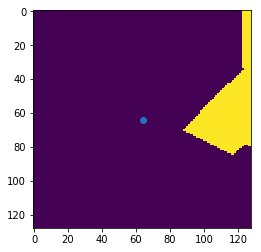

In [15]:
testim = val['img'].sample(n=1).iloc[0]
plt.imshow(testim)
plt.scatter([testim.shape[0]//2], [testim.shape[1]//2])
print(looking_at_white(testim))

In [16]:
df = load_images(df)

  2%|▏         | 129/6548 [00:00<00:04, 1287.46it/s]

row mapping raw_img


  3%|▎         | 166/6548 [00:00<00:03, 1656.56it/s]

row mapping normed_img


  8%|▊         | 526/6548 [00:00<00:01, 5259.58it/s]

flip augmentation


100%|██████████| 6548/6548 [00:01<00:00, 5609.11it/s]


In [22]:
loophits = val[(val['y'] == 0) & (val['img'].map(looking_at_white))]

In [23]:
len(loophits)

121

In [24]:
vx, vy = assemble.df_to_xy(loophits, dict(input_shape=(128,128,1)))
ohvy = onehot(vy)

In [27]:
pvy = md.predict(vx, batch_size=16)

In [28]:
[for p]

array([[7.72855431e-02, 9.22714412e-01],
       [9.99850035e-01, 1.49916130e-04],
       [9.99999523e-01, 5.08366611e-07],
       [9.30141568e-01, 6.98584765e-02],
       [9.80262399e-01, 1.97376646e-02],
       [9.49664712e-01, 5.03352843e-02],
       [9.95676458e-01, 4.32356354e-03],
       [9.99982595e-01, 1.74362358e-05],
       [2.96166956e-01, 7.03833044e-01],
       [1.44499943e-01, 8.55500102e-01],
       [9.91361320e-01, 8.63873214e-03],
       [2.51962841e-02, 9.74803686e-01],
       [9.97893631e-01, 2.10642884e-03],
       [1.49441496e-01, 8.50558519e-01],
       [9.99931455e-01, 6.85251216e-05],
       [1.04914054e-01, 8.95085990e-01],
       [9.99752700e-01, 2.47241580e-04],
       [9.99986291e-01, 1.37241523e-05],
       [2.89515197e-01, 7.10484803e-01],
       [9.99999285e-01, 7.06910441e-07],
       [9.99999762e-01, 2.04309174e-07],
       [9.87490475e-01, 1.25095164e-02],
       [9.99985218e-01, 1.48170584e-05],
       [1.00000000e+00, 2.41558276e-08],
       [9.998326